In [1]:
%matplotlib inline

In [2]:
from adaptmesh import triangulate
import numpy as np

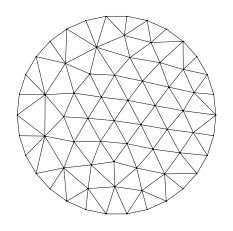

In [5]:
m = triangulate([(np.cos(t), np.sin(t)) for t in np.linspace(0, 2.*np.pi, 30, endpoint=False)])
m.draw()

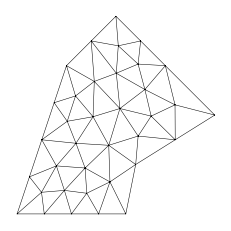

In [8]:
m = triangulate([
    (0.0, 0.0),
    (1.1, 0.0),
    (1.2, 0.5),
    (0.7, 0.6),
    (2.0, 1.0),
    (1.0, 2.0),
    (0.5, 1.5),], max_refloops=15, quality=0.9)
m.draw()

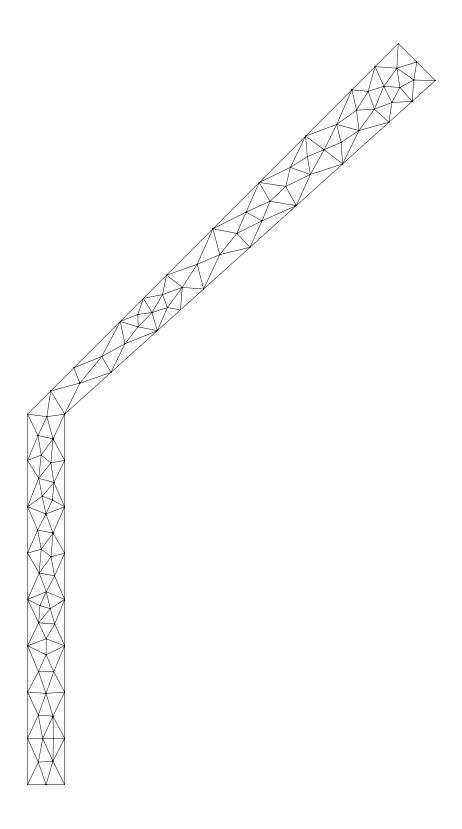

In [10]:
m = triangulate([
    (0.0, 0.0),
    (5.0, 5.0),
    (5.5, 4.5),
    (0.5, 0.0),
    (0.5, -5.0),
    (0., -5.0),], max_refloops=30, quality=0.7)
m.draw(figsize=(15,15))

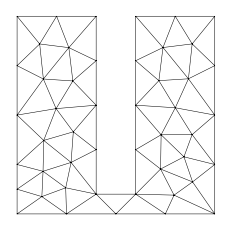

In [12]:
m = triangulate([(0., 0.),
              (1., 0.),
              (1., 1.),
              (.6, 1.),
              (.6, .1),
              (.4, .1),
              (.4, 1.),
              (0., 1.)])
m.draw()

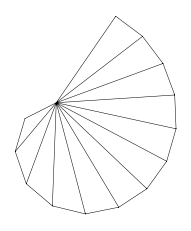

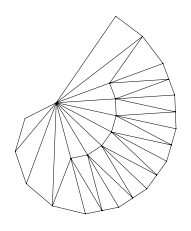

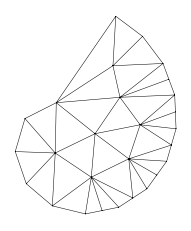

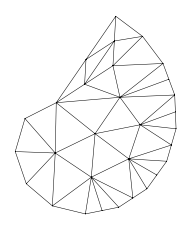

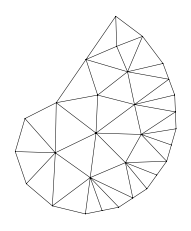

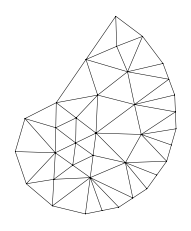

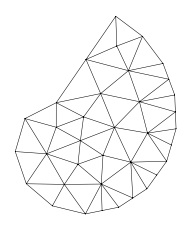

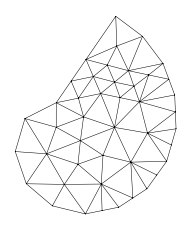

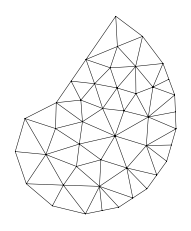

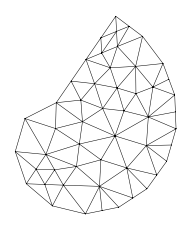

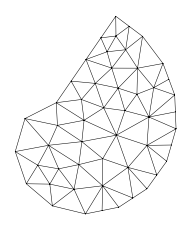

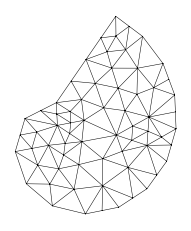

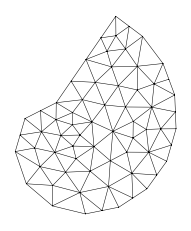

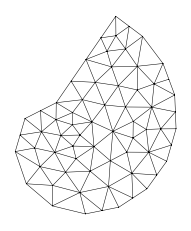

In [7]:
m = triangulate([
(-0.416  , 0.909),
(-1.35  ,  0.436),
(-1.64  , -0.549),
(-1.31  , -1.51),
(-0.532  ,-2.17),
( 0.454 , -2.41),
( 1.45 ,  -2.21),
( 2.29 ,  -1.66),
( 2.88 ,  -0.838),
( 3.16 ,   0.131),
( 3.12 ,   1.14),
( 2.77 ,   2.08),
( 2.16 ,   2.89),
( 1.36 ,   3.49)], verbose=True)
m.draw()

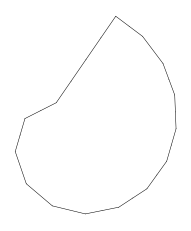

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
aspect = 1.0
ax.set_aspect(aspect)
ax.set_axis_off()
plt.plot(m.p[0, m.facets[:, m.boundary_facets()]], m.p[1, m.facets[:, m.boundary_facets()]], 'k-',linewidth='0.5')

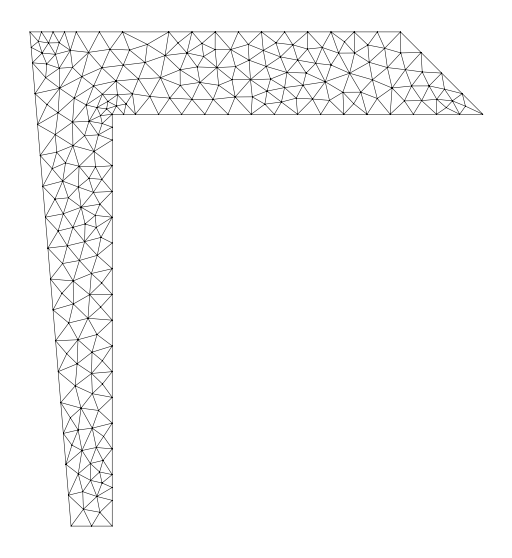

In [16]:
m = triangulate([(0.,0.),
              (0.1,0.),
              (0.1,1.0),
              (1.,1.),
              (0.8,1.2),
              (-0.1,1.2),]) 
m.draw(figsize=(10,10))

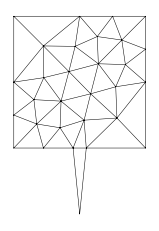

In [17]:
m = triangulate([(0.,0.),
              (0.45,0.),
              (0.5,-0.5),
              (0.55,0.),
              (1.,0.),
              (1.,1.),
             (0.,1.)]) 
m.draw()